# Optogenetic Control of *Drosophila* Courtship Behavior
## Step 1: Format Recording


In [41]:
import neo, os
import numpy as np
from mne import create_info
from mne.io import RawArray

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define files.
files = sorted(os.listdir('raw'))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main body.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

for f in files:

    ## Load recording segment.
    segment, = neo.AxonIO(filename='raw/%s' %f).read_block().segments
    
    ## Unpack channel traces.
    audio, opto, _ = segment.analogsignals
    
    ## Concatenate raw recordings.
    data = np.hstack([np.asarray(audio, dtype=np.float64) * 1e-6, # uV
                      np.asarray(opto, dtype=np.float64)          # V
                     ]).T 
    
    ## Create info object.
    sfreq = float(audio.sampling_rate)
    ch_names = ['audio', 'opto']
    ch_types = ['bio', 'stim']

    info = create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

    ## Create Raw object.
    raw = RawArray(data, info, verbose=False)

    ## Save Raw object.
    raw.save('raw/%s_raw.fif' %f.replace('.abf',''), overwrite=True, verbose=False)
    
print('Done.')

## Step 2: 

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mne import pick_channels
from mne.io import Raw
from scipy.ndimage import measurements
sns.set_style('white')
sns.set_context('notebook', font_scale=2)
%matplotlib inline

def find_threshold(arr, k):
    return k * np.median( np.abs(arr) ) / 0.6745

def peak_finder(x0, thresh):
    '''Simple peak finding algorithm.'''
    assert x0.ndim == 1
    clusters, ix = measurements.label(x0 > thresh)
    peak_loc = np.concatenate(measurements.maximum_position(x0, labels=clusters, index=np.arange(ix)+1))
    peak_mag = measurements.maximum(x0, labels=clusters, index=np.arange(ix)+1)
    return peak_loc, peak_mag

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
f = 'raw/17n27003-stimulation_p1_1_raw.fif'

## Filter parameters.
l_freq = 100
h_freq = 3000

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load raw.
raw = Raw(f, preload=True, verbose=False)

## Filter data.
picks = pick_channels(raw.ch_names, include=['audio'])
raw = raw.filter(l_freq, h_freq, picks=picks, method='fir', phase='zero', fir_design='firwin')

In [110]:
threshold = 100e-6
peak_loc, peak_mag = peak_finder(raw._data[0], threshold)

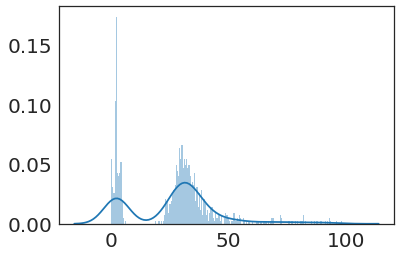

In [111]:
d = np.diff(raw.times[peak_loc])
d = d[d < 0.1]
sns.distplot(d*1e3, bins=200)

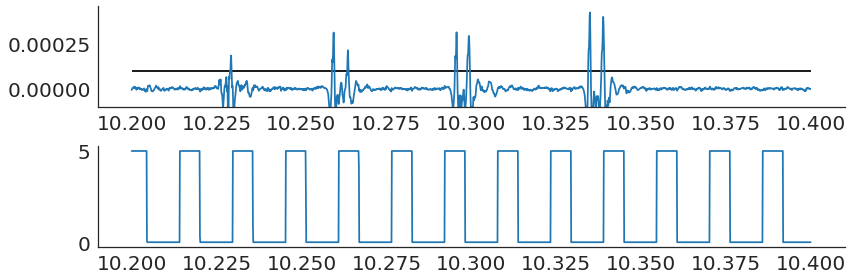

In [118]:
tmin = 10.2
tmax = 10.4
threshold = 100e-6


data, times = raw.get_data(start=raw.time_as_index(tmin)[0], stop=raw.time_as_index(tmax)[0], return_times=True)
fig, axes = plt.subplots(2,1,figsize=(12,4))
axes[0].plot(times, data[0])
axes[0].hlines(threshold, tmin, tmax)
axes[0].set(ylim=(-threshold))
axes[1].plot(times, data[1])

sns.despine()
plt.tight_layout()

In [138]:
from scipy.io import loadmat
mat = loadmat('raw/17n27003-stimulation_p1_1.mat')
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'd', 'pulses', 'sines', 'times'])

In [139]:
mat['d'].shape

(3673088, 3)

In [140]:
mat['pulses'].shape

(4, 1738)

In [141]:
mat['sines'].shape

(3, 715)

In [142]:
mat['times'].shape

(1, 3673088)